# Facial Recognition
## November 23rd, 2021
### Overview: Given a collection of images of human faces, learn to identify and match a face in a new image with one from the collection.

In [1]:
import os
import numpy as np
from imageio import imread
from scipy import linalg as la
from matplotlib import pyplot as plt

## Helper Functions: 
- get_faces: Retrieves face images, flattens and converts them to grayscale
- sample_faces: repeatedly yield (when called) a face image
- show: shows image

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))
        
def show(image, m=200, n=180,ax=None):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    #reshaping the flattened image array and plotting
    image = image.reshape((m,n))
    #if an axis is given (for subplotting), plot on the axis; otherwise default plot
    if ax == None:
        plt.imshow(image,cmap='gray')
    else:
        ax.imshow(image,cmap='gray')

## Creation of Facial Recognition object, FacialRec
- Constructor: fetches all faces, shifts each by the mean, and retrieves the U matrix from the compact SVD (the columns of which are orthonormal "eigenfaces" or eigen basis vectors for the space of faces)
- project: projects a face image array onto the eigenspace
- find_nearest: finds closest (in terms of the 2-norm) face image relative to projected face
- match: display image with its match

In [4]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        #getting the box of faces
        self.F = get_faces(path)
        
        #average face
        self.mu = np.sum(self.F,axis=1)/self.F.shape[1]
        
        #mean-shifted box of faces
        self.Fbar = (self.F.T - self.mu).T
        
        #svd
        self.U = la.svd(self.F,full_matrices = False)[0]
        
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        #returning projected image
        return self.U.T[:s,:]@A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        #projecting for F_hat and g_hat
        F_hat = self.project(self.F,s)
        g_hat = self.project(g,s)
        
        #finding index of minimum difference between images
        j = np.argmin(la.norm((  F_hat.T - g_hat).T,  axis=0))
        
        return j

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        #formatting plots
        fig, axs = plt.subplots(nrows=1,ncols=2)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        fig.set_size_inches(9.25, 5.25)
        axs[0].set_title('Given Face')
        axs[1].set_title('Matching Face')
        
        #showing given face, getting index of nearest match and showing that
        show(image,ax=axs[0])
        j = self.find_nearest(image,s)
        show(self.F.T[j],ax=axs[1])
        plt.show()

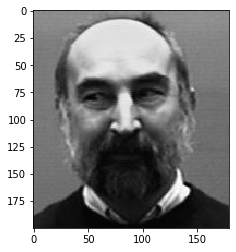

In [5]:
# showing a face
f = FacialRec()
show(f.F.T[134])

## Presentation - Faces
- Using FacialRec object declared above, display the mean face, original image, and image shifted by the mean face

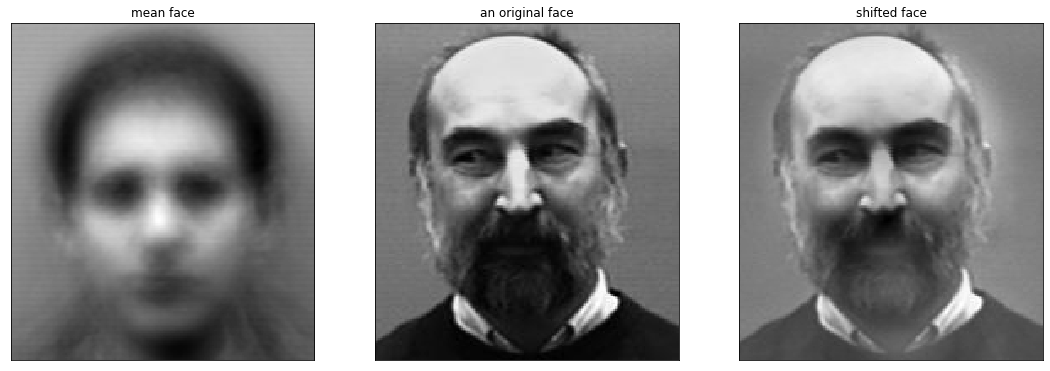

In [6]:
#formatting plot
fig, axs = plt.subplots(nrows=1,ncols=3)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
fig.set_size_inches(18.5, 10.5)

#plotting mean face, shifty grandpa, and shifty grandpa's shifted face
axs[0].set_title('mean face')
show(f.mu,ax=axs[0])
axs[1].set_title('an original face')
show(f.F.T[134],ax=axs[1])
axs[2].set_title('shifted face')
show(f.Fbar.T[134],ax=axs[2])

## Presentation - Eigenfaces

- Using the same FacialRec object, display a few of the eigen faces


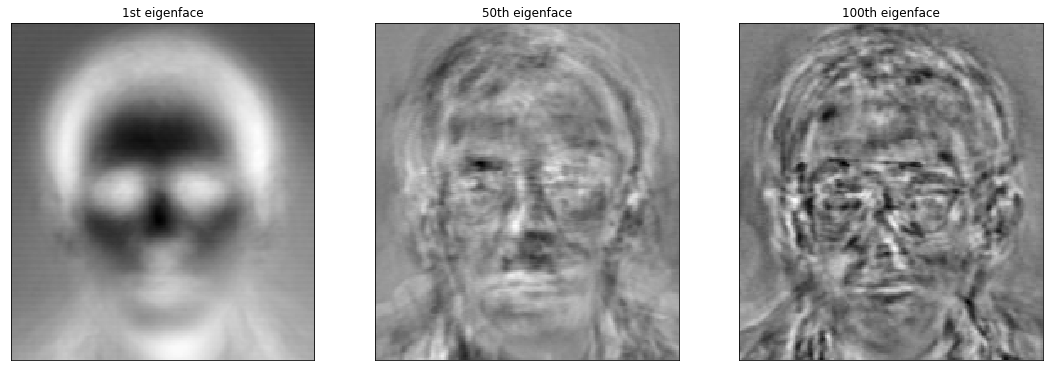

In [7]:
#formatting plot
fig, axs = plt.subplots(nrows=1,ncols=3)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
fig.set_size_inches(18.5, 10.5)

#plotting 1st, 50th, and 100th eigenfaces
axs[0].set_title('1st eigenface')
show(f.U[:,0],ax=axs[0])
axs[1].set_title('50th eigenface')
show(f.U[:,49],ax=axs[1])
axs[2].set_title('100th eigenface')
show(f.U[:,99],ax=axs[2])

## Presentation - Projection Reconstruction

- Using various values of s, the number of eigenfaces to project onto, reconstruct an image with these basis vectors

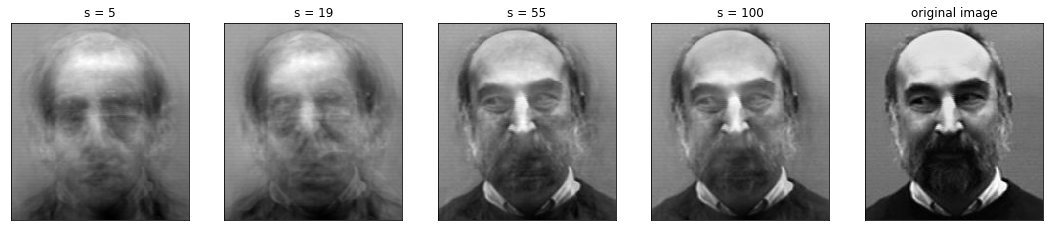

In [8]:
#s values to use
S = [5,19,75,100]

#formatting plot
fig, axs = plt.subplots(nrows=1,ncols=5)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
fig.set_size_inches(18.5, 10.5)
axs[0].set_title('s = 5')
axs[1].set_title('s = 19')
axs[2].set_title('s = 55')
axs[3].set_title('s = 100')
axs[4].set_title('original image')

#plotting each reconstructed image and the original
for i in range(4):
    show(f.U[:,:S[i]]  @   f.project(f.F[:,134],S[i]) + f.mu,ax=axs[i])
show(f.F.T[134],ax=axs[4])

## Presentation - Displaying Matches

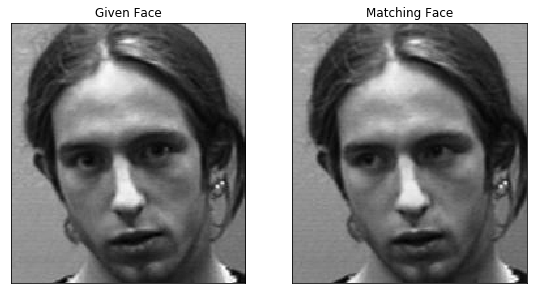

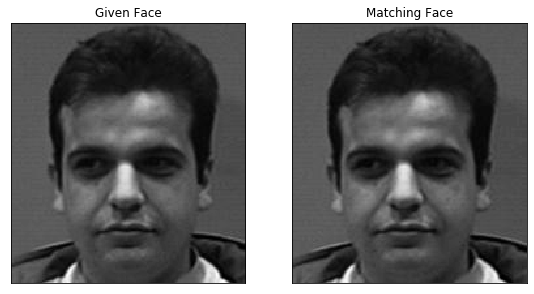

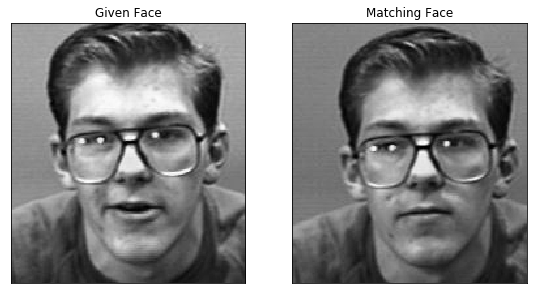

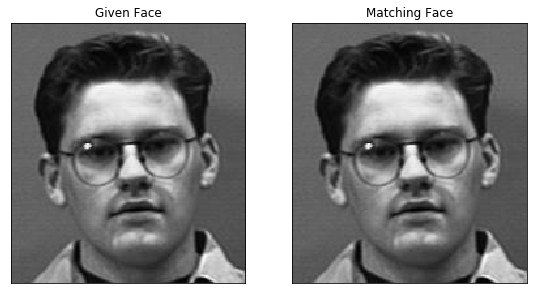

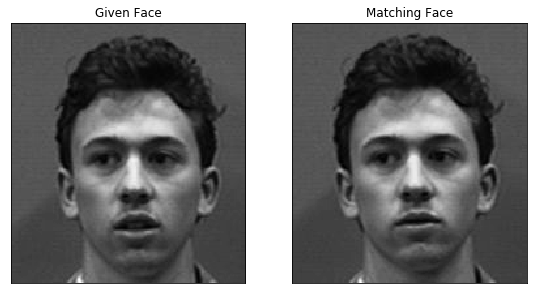

In [10]:
#generating 5 random sample faces and showing closest match
for test_image in sample_faces(5):
    f.match(test_image)